# Predicting House Prices in California

I try a couple of different approaches, holding a simple Linear Regression as the base case, followed by more advanced regression techniques. The analysis, methodology and results are presented in the cells below.

### Loading the data

In [94]:
import pandas as pd
housing  = pd.read_csv('housing.csv')
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
5,-122.25,37.85,52,919,213.0,413,193,4.0368,269700,NEAR BAY
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,299200,NEAR BAY
7,-122.25,37.84,52,3104,687.0,1157,647,3.1200,241400,NEAR BAY
8,-122.26,37.84,42,2555,665.0,1206,595,2.0804,226700,NEAR BAY
9,-122.25,37.84,52,3549,707.0,1551,714,3.6912,261100,NEAR BAY


### Inspecting the data

In [95]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null int64
total_rooms           20640 non-null int64
total_bedrooms        20433 non-null float64
population            20640 non-null int64
households            20640 non-null int64
median_income         20640 non-null float64
median_house_value    20640 non-null int64
ocean_proximity       20640 non-null object
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [96]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

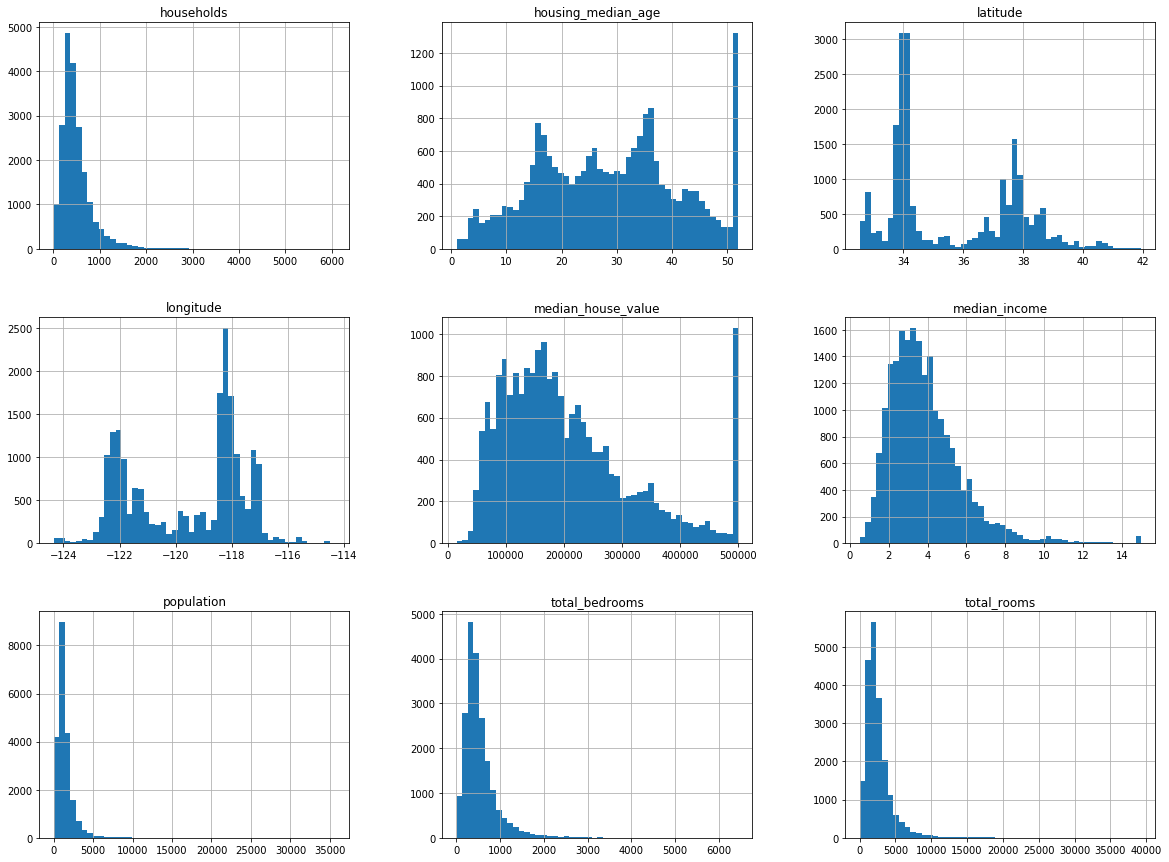

In [97]:
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [98]:
print ("Number of applications: %d" % (len(housing)))
print ("Number of NaNs: %d" % (housing.isnull().values.sum()))

Number of applications: 20640
Number of NaNs: 207


### Splitting the data

In [99]:
import numpy as np
# to make this notebook's output identical at every run
np.random.seed(40)

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=40)
print ("train set: ", len(train_set))
print ("test set: ", len(test_set))
print ("Number of NaNs training: %d" % (train_set.isnull().values.sum()))
print ("Number of NaNs testing: %d" % (test_set.isnull().values.sum()))


train set:  16512
test set:  4128
Number of NaNs training: 160
Number of NaNs testing: 47


### Visualizing attributes

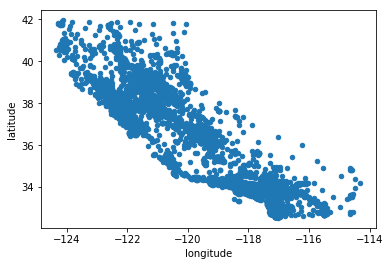

In [100]:
train_set.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

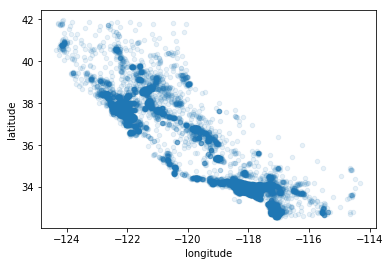

In [101]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

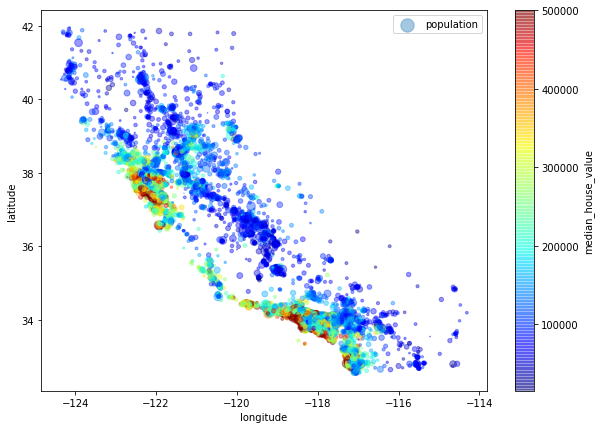

In [102]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

### Analyzing attributes

In [103]:
corr_matrix = train_set.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689565
total_rooms           0.136670
housing_median_age    0.104681
households            0.065653
total_bedrooms        0.049700
population           -0.022397
longitude            -0.048351
latitude             -0.142562
Name: median_house_value, dtype: float64

### Imputing data

In [104]:
housing_train = train_set.drop("median_house_value", axis=1) 
housing_labels = train_set["median_house_value"].copy()
housing_test = test_set.drop("median_house_value", axis=1) 
housing_test_labels = test_set["median_house_value"].copy()

sample_incomplete_rows = housing_train[housing_train.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5665,-118.29,33.73,30,3161,NaN,1865,771,2.7139,NEAR OCEAN
10915,-117.87,33.73,45,2264,NaN,1970,499,3.4193,<1H OCEAN
7763,-118.10,33.91,36,726,NaN,490,130,3.6389,<1H OCEAN
7668,-118.08,33.92,38,1335,NaN,1011,269,3.6908,<1H OCEAN
7547,-118.20,33.92,45,1283,NaN,1025,248,3.2798,<1H OCEAN


In [105]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

# remove the text feature because median can only be calculated on numerical attributes
housing_num_train = housing_train.drop("ocean_proximity", axis=1)
housing_num_test = housing_test.drop("ocean_proximity", axis=1)

imputer.fit(housing_num_train)
imputer.statistics_


array([-118.49  ,   34.25  ,   29.    , 2127.    ,  436.    , 1168.    ,
        410.    ,    3.5313])

In [106]:
X = imputer.transform(housing_num_train)
housing_train = pd.DataFrame(X, columns=housing_num_train.columns, index = list(housing_train.index.values))
housing_train.loc[sample_incomplete_rows.index.values]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
5665,-118.29,33.73,30.0,3161.0,436.0,1865.0,771.0,2.7139
10915,-117.87,33.73,45.0,2264.0,436.0,1970.0,499.0,3.4193
7763,-118.10,33.91,36.0,726.0,436.0,490.0,130.0,3.6389
7668,-118.08,33.92,38.0,1335.0,436.0,1011.0,269.0,3.6908
7547,-118.20,33.92,45.0,1283.0,436.0,1025.0,248.0,3.2798


In [107]:
X_test = imputer.transform(housing_num_test)
housing_test = pd.DataFrame(X_test, columns=housing_num_test.columns, index = list(housing_test.index.values))


### Encoding attributes

In [108]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat_train = train_set["ocean_proximity"]
housing_cat_test = test_set["ocean_proximity"]
housing_cat_encoded_train = encoder.fit_transform(housing_cat_train)
housing_cat_encoded_test = encoder.fit_transform(housing_cat_test)

housing_cat_encoded_train

array([1, 1, 0, ..., 4, 0, 0], dtype=int64)

In [109]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [110]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot_train = encoder.fit_transform(housing_cat_encoded_train.reshape(-1,1))
housing_cat_1hot_test = encoder.fit_transform(housing_cat_encoded_test.reshape(-1,1))

housing_cat_1hot_train

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [111]:
housing_cat_1hot_train.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [112]:
housing_prepared_train = np.hstack((housing_train.values,housing_cat_1hot_train.toarray()) )
housing_prepared_test = np.hstack((housing_test.values,housing_cat_1hot_test.toarray()) )

### Model training

In [113]:
from sklearn.linear_model import LinearRegression

# Create a baseline without any training
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared_train, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [114]:
# Grab some data
some_data = housing_prepared_train[:5]
some_labels = housing_labels[:5]
print ("Predictions:", lin_reg.predict(some_data))


Predictions: [ 88355.78241352 165952.64138854 125166.48761098 215328.41290358
 256844.47581861]


In [115]:
print("Ground truth values:", list(some_labels))

Ground truth values: [63300, 174300, 350000, 268800, 385900]


In [116]:
#Compute the error according to various "loss" functions
from sklearn.metrics import mean_squared_error, mean_absolute_error

housing_predictions = lin_reg.predict(housing_prepared_train)
lin_mse  = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print ("Training error")
print ("Root of mean squared error: ", lin_rmse)
print ("Mean absolute error: ", lin_mae)


Training error
Root of mean squared error:  68592.34198722034
Mean absolute error:  49643.6282508512


In [117]:
housing_predictions_test = lin_reg.predict(housing_prepared_test)
lin_mse  = mean_squared_error(housing_test_labels, housing_predictions_test)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(housing_test_labels, housing_predictions_test)

print ("Test error")
print ("Root of mean squared error: ", lin_rmse)
print ("Mean absolute error: ", lin_mae)


Test error
Root of mean squared error:  69234.3174744366
Mean absolute error:  50305.41011310988


### Improving Performance

3-fold Cross-validation is implemented below for linear regression

In [118]:
from sklearn.model_selection import cross_validate, train_test_split

np.random.seed(42)

clf = LinearRegression()
scoring = {'neg_mse': 'neg_mean_squared_error', 'neg_mae': 'neg_mean_absolute_error'}
cv_results = cross_validate(clf, housing_prepared_train, housing_labels, scoring=scoring, return_train_score=True, cv = 3)

print ("Training error")
print ("Root of mean squared error: ", [np.sqrt(-x) for x in cv_results['train_neg_mse']])
print ("Mean absolute error: ", [-x for x in cv_results['train_neg_mae']])

print ("")

print ("Testing error")
print ("Root of mean squared error: ", [np.sqrt(-x) for x in cv_results['test_neg_mse']])
print ("Mean absolute error: ", [-x for x in cv_results['test_neg_mae']])

Training error
Root of mean squared error:  [68427.0281338334, 68159.94185416572, 69037.58749375644]
Mean absolute error:  [49584.454100889205, 49338.01248326344, 49985.03290958627]

Testing error
Root of mean squared error:  [69025.65384334647, 69675.8155484955, 67879.60359738879]
Mean absolute error:  [50145.55479370437, 49966.57736961318, 49207.56446900329]


3-fold RMSE values are quite similar for each of the CV samples v/s the RMSE for overall data. Moving on to other regression models!

Below I implement the Boosted trees model using the default parameters. It is quite apparent that it easily outperforms the baseline Linear Regression model regardless of whether measured by RMSE or MAE. The other regressor I choose is the Huber regressor which is a form of robust regression that takes into account outliers through its hybrid objective function based on the Huber loss function. A lot of the features in our data have outliers and I thought this would be more valuable to the problem than a Ridge/lasso regularized regression, seeing that we do not have that many features in the first place!

### Gradient Boosted Decision Trees

In [119]:
from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(42)

clf = GradientBoostingRegressor()
scoring = {'neg_mse': 'neg_mean_squared_error', 'neg_mae': 'neg_mean_absolute_error'}
cv_results = cross_validate(clf, housing_prepared_train, housing_labels, scoring=scoring, return_train_score=True, cv = 3)

print ("Training error")
print ("Root of mean squared error: ", [np.sqrt(-x) for x in cv_results['train_neg_mse']])
print ("Mean absolute error: ", [-x for x in cv_results['train_neg_mae']])

print ("")

print ("Testing error")
print ("Root of mean squared error: ", [np.sqrt(-x) for x in cv_results['test_neg_mse']])
print ("Mean absolute error: ", [-x for x in cv_results['test_neg_mae']])

Training error
Root of mean squared error:  [52111.51165166485, 51667.83385536141, 52752.988499677536]
Mean absolute error:  [36274.90920147295, 36236.05003604621, 36907.27226956155]

Testing error
Root of mean squared error:  [55006.72900729443, 55824.11090427891, 54069.10960235636]
Mean absolute error:  [38184.08409514789, 38675.09025397275, 37496.21779380427]


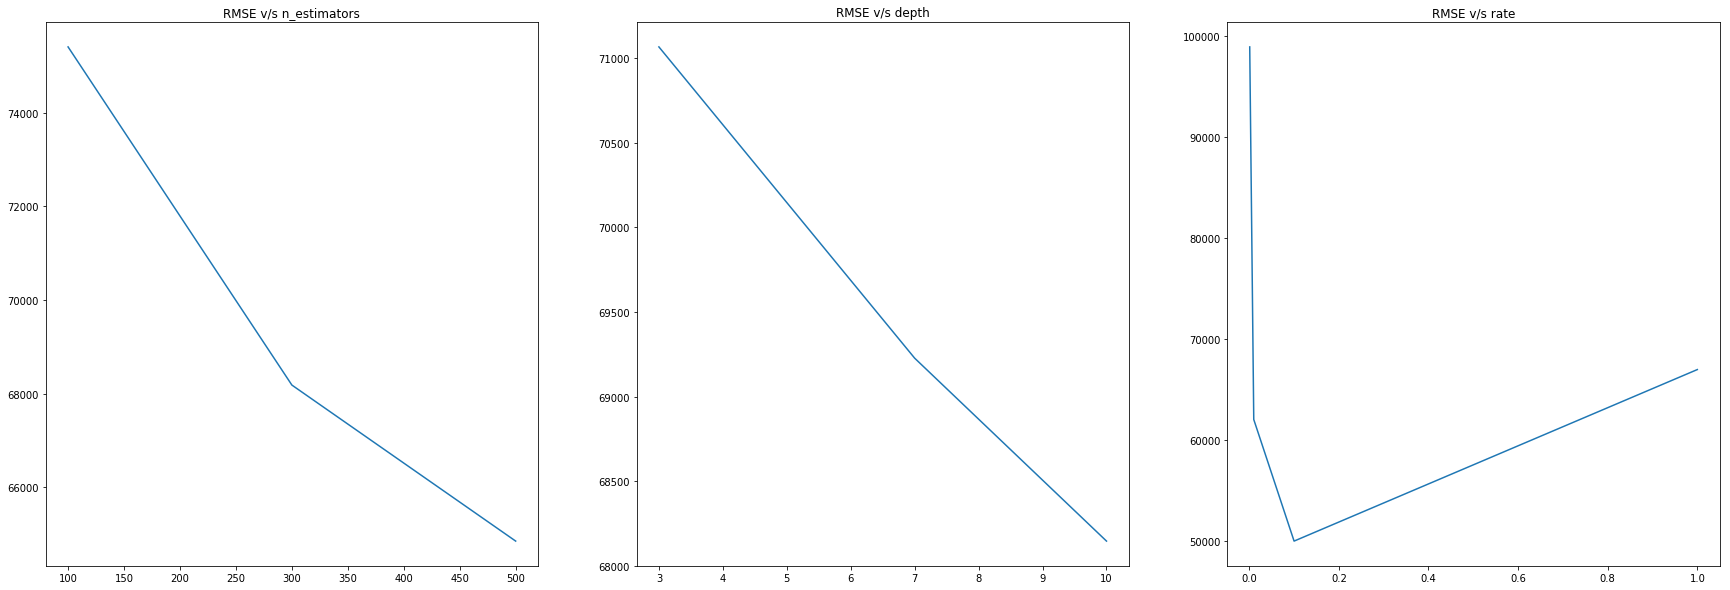

In [120]:
gbd_all_data = []

for n_estimators in [100, 300, 500]:
    for depth in [3, 7, 10]:
        for rate in [0.001, 0.01, 0.1, 1.0]:
            clf = GradientBoostingRegressor(learning_rate = rate, n_estimators = n_estimators, max_depth = depth)
            clf.fit(housing_prepared_train, housing_labels)
            housing_predictions_test = clf.predict(housing_prepared_test)
            rmse_error = np.sqrt(mean_squared_error(housing_test_labels, housing_predictions_test))
            gbd_all_data.append([n_estimators, depth, rate, rmse_error])
            """
            print ("RMSE for %d estimators with max tree depth of %d and learning at a rate of %f: %f"
                   % (n_estimators, depth, rate, np.sqrt(mean_squared_error(housing_test_labels, housing_predictions_test))))
            """
            
gbd_all_data = pd.DataFrame(gbd_all_data, columns = ['n_estimators', 'depth', 'rate', 'rmse_error'])
plt.figure(figsize = (30,10))
for i, col in enumerate(list(gbd_all_data.columns)[:-1]):
    _temp = gbd_all_data.groupby(col)['rmse_error'].mean()
    plt.subplot(1, 3, i+1)
    plt.plot(_temp)
    plt.title('RMSE v/s ' + col)
plt.show()

### Huber Regressor

In [121]:
from sklearn.linear_model import HuberRegressor

np.random.seed(42)

clf = HuberRegressor()
scoring = {'neg_mse': 'neg_mean_squared_error', 'neg_mae': 'neg_mean_absolute_error'}
cv_results = cross_validate(clf, housing_prepared_train, housing_labels, scoring=scoring, return_train_score=True, cv = 3)

print ("Training error")
print ("Root of mean squared error: ", [np.sqrt(-x) for x in cv_results['train_neg_mse']])
print ("Mean absolute error: ", [-x for x in cv_results['train_neg_mae']])

print ("")

print ("Testing error")
print ("Root of mean squared error: ", [np.sqrt(-x) for x in cv_results['test_neg_mse']])
print ("Mean absolute error: ", [-x for x in cv_results['test_neg_mae']])

Training error
Root of mean squared error:  [74032.57769277887, 75366.42997019255, 76357.57690560326]
Mean absolute error:  [51712.05439667426, 53244.43908801517, 54798.05236178151]

Testing error
Root of mean squared error:  [73648.00915946902, 79128.8946773772, 73390.31630579945]
Mean absolute error:  [51575.02962886456, 54474.45699893351, 53755.959471850634]


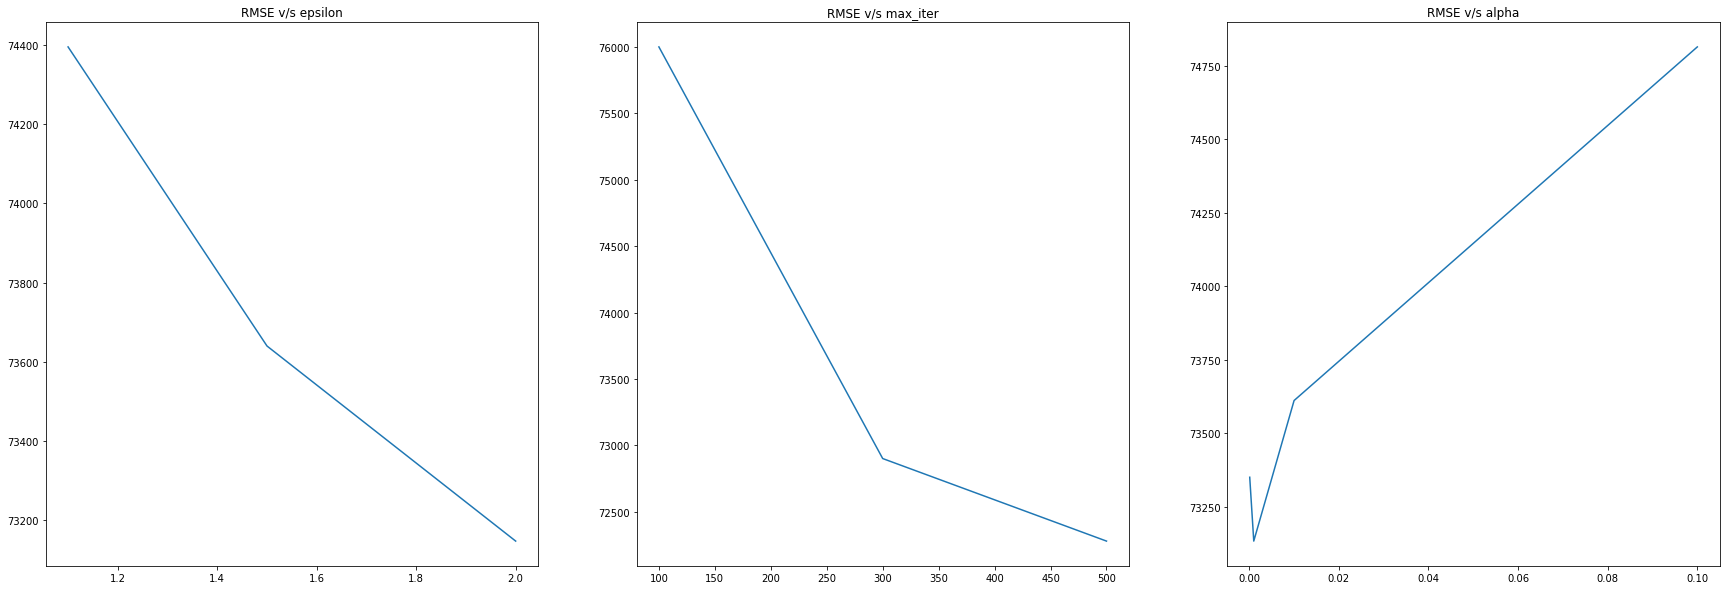

In [122]:
huber_data = []

for epsilon in [1.1, 1.5, 2]:
    for max_iter in [100, 300, 500]:
        for alpha in [0.0001, 0.001, 0.01, 0.1]:
            clf = HuberRegressor(epsilon, max_iter, alpha)
            clf.fit(housing_prepared_train, housing_labels)
            housing_predictions_test = clf.predict(housing_prepared_test)
            rmse_error = np.sqrt(mean_squared_error(housing_test_labels, housing_predictions_test))
            huber_data.append([epsilon, max_iter, alpha, rmse_error])
            """
            print ("RMSE for epsilon of %f with max optimization iterations of %d and regularization parameter of %f: %f"
                   % (epsilon, max_iter, alpha, rmse_error))
            """
huber_data = pd.DataFrame(huber_data, columns = ['epsilon', 'max_iter', 'alpha', 'rmse_error'])
plt.figure(figsize = (30,10))
for i, col in enumerate(list(huber_data.columns)[:-1]):
    _temp = huber_data.groupby(col)['rmse_error'].mean()
    plt.subplot(1, 3, i+1)
    plt.plot(_temp)
    plt.title('RMSE v/s ' + col)
plt.show()

### Analysis

Gradient Boosted regression trees are much better than baseline linear regression. More tree depth, larger number of trees and lower learning rate improve the model (reduce RMSE)

Huber regression performed worse than the baseline model. While there were trends in the RMSE versus the hyperparameter values, the magnitude of change in the RMSE values was largely insignificant. The trends can be seen in the chart above.